In [1]:
# numpy and pandas for data manipulation
import pandas as pd 
import numpy as np

# sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#gestion du desiquilibre de la classe TARGET
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

#Boosting lightgbm
from lightgbm import LGBMClassifier

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#regEX
import re
from collections import Counter

#serialisation du modele
import pickle

#mesure du temps
import timeit

#  UTILISATION d'une selection dans le jeu complet de données

selection faite dans kernel kaggle : https://www.kaggle.com/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit

In [2]:
df_features = pd.read_csv('app_train_encoded.csv')
df_features

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,WALLSMATERIAL_MODE_nan,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,EMERGENCYSTATE_MODE_nan
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,9461,-637.0,-3648.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765,-1188.0,-1186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,19046,-225.0,-4260.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,19005,-3039.0,-9833.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,19932,-3038.0,-4311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307500,456251,0,157500.0,254700.0,27558.0,225000.0,0.032561,9327,-236.0,-8456.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307501,456252,0,72000.0,269550.0,12001.5,225000.0,0.025164,20775,NaN,-4388.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307502,456253,0,153000.0,677664.0,29979.0,585000.0,0.005002,14966,-7921.0,-6737.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
307503,456254,0,171000.0,370107.0,20205.0,319500.0,0.005313,11961,-4786.0,-2562.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [4]:
X_features = df_features.drop(columns='TARGET').copy()
y_features= df_features['TARGET'].copy()

## imputation valeurs simples

In [5]:
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
col_num = list(df_features.select_dtypes('float64').columns)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_features[col_num] = imp_mean.fit_transform(df_features[col_num])

In [6]:
col_num = list(df_features.select_dtypes('int64').columns)
imp_meanN = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
df_features[col_num] = imp_meanN.fit_transform(df_features[col_num])

In [43]:
X_feats_impute = df_features.drop(columns='TARGET').copy()
y_feats_impute = df_features['TARGET'].copy()

### separation train/test set

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_feats_impute, y_feats_impute, test_size=0.2, stratify=y_feats_impute, random_state=1944)
X_feats_train, X_feats_val, y_feats_train, y_feats_val = train_test_split(X_features, y_features, test_size=0.2, stratify=y_features, random_state=1944)

In [45]:
print('y_train', Counter(y_train))
print('y_val', Counter(y_val))

y_train Counter({0.0: 226144, 1.0: 19860})
y_val Counter({0.0: 56536, 1.0: 4965})


# definition metrique et fonction evaluation

### Score métier = 10*FN + FP

In [46]:
import os
import mlflow
import mlflow.sklearn
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score, roc_curve, auc
)
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.dummy import DummyClassifier

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri("file:///C:/Users/saidi/Projet_7/mlruns/mlruns")

def set_experiment_name(model_name):
    """
    Configure l'expérience MLflow en fonction du modèle.
    """
    experiment_name = f"Projet 7 - {model_name}"
    mlflow.set_experiment(experiment_name)

def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FMI = np.sqrt(PPV * TPR) if PPV and TPR else 0
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

def custom_cost(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp + 10 * fn
    max_cost = 10 * len(y_true)
    cost_normalized = cost / max_cost
    return cost_normalized

def safe_metric(metric_func, y_true, y_pred, *args, **kwargs):
    try:
        return metric_func(y_true, y_pred, *args, **kwargs)
    except ValueError:
        return float('nan')

def model_eval_score(model, Xval, yval, strategy):
    with mlflow.start_run:
        yval_pred = model.predict(Xval)
        yval_proba = model.predict_proba(Xval)[:, 1]
        
        conf_mat = confusion_matrix(yval, yval_pred)
        accuracy = accuracy_score(yval, yval_pred)
        precision = safe_metric(precision_score, yval, yval_pred)
        recall = safe_metric(recall_score, yval, yval_pred)
        f1 = safe_metric(f1_score, yval, yval_pred)
        f2 = safe_metric(fbeta_score, yval, yval_pred, beta=2)
        rocauc = safe_metric(roc_auc_score, yval, yval_pred)
        custom_metric_value = safe_metric(custom_metric, yval, yval_pred)
        custom_cost_value = custom_cost(yval, yval_proba)
        
        # Log metrics to MLflow
        mlflow.log_param("Strategy", strategy)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("F2", f2)
        mlflow.log_metric("ROCAUC", rocauc)
        mlflow.log_metric("Custom Metric FMI", custom_metric_value)
        mlflow.log_metric("Custom Cost", custom_cost_value)
        
        # Print metrics with updated formatting
        print(conf_mat)
        print(f'Accuracy score    : {accuracy:.3f}')
        print(f'Precision score   : {precision:.3f}')
        print(f'Recall score      : {recall:.3f}')
        print(f'F1 score          : {f1:.3f}')
        print(f'F2 score          : {f2:.3f}')
        print(f'ROCAUC score      : {rocauc:.3f}')
        print(f'Custom metric FMI : {custom_metric_value:.3f}')
        print(f'Custom cost       : {custom_cost_value:.3f}')
        print()

def model_eval(model, Xval, yval, strategy):
    start_time_fit = time.time()
    model.fit(Xval, yval)
    elapsed_time_fit = time.time() - start_time_fit

    start_time_predict = time.time()
    model_eval_score(model, Xval, yval, strategy)
    elapsed_time_predict = time.time() - start_time_predict

    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    # Save ROC curve plot
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc_curve.png')  # Save the plot
    plt.close()  # Close the plot to free memory

    # Log ROC curve plot to MLFlow
    mlflow.log_artifact('roc_curve.png')

    # Log times to MLFlow
    mlflow.log_metric("Fit Time", elapsed_time_fit)
    mlflow.log_metric("Prediction Time", elapsed_time_predict)

    # Log the model to MLFlow
    mlflow.sklearn.log_model(model, "model")

    # Optionally display the ROC curve
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [47]:
import warnings
warnings.filterwarnings('ignore', message='Distutils was imported before Setuptools')
warnings.filterwarnings('ignore', message='Setuptools is replacing distutils')

import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time
import lightgbm as lgb

# Charger les données
df_classification_imputed = pd.read_csv('app_train_encoded.csv')  # Remplacez par le chemin de vos données

nb_0 = (df_classification_imputed['TARGET'] == 0).sum()
nb_1 = (df_classification_imputed['TARGET'] == 1).sum()

X_train = df_classification_imputed.drop(columns=["TARGET", "SK_ID_CURR"])
Y_train = df_classification_imputed["TARGET"]

# Convertir les colonnes en type float pour éviter les problèmes avec les NaN
X_train = X_train.astype(float)

# Remplacer les valeurs infinies par NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Imputer les valeurs manquantes par la moyenne des colonnes
X_train.fillna(X_train.mean(), inplace=True)

# StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Class weights
class_weights = {0: 1, 1: nb_0 / nb_1}

# Fonction pour calculer le coût personnalisé
def custom_cost(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = fp + 10 * fn
    max_cost = 10 * len(y_true)
    cost_normalized = cost / max_cost
    return cost_normalized

#Fonction pour entraîner et évaluer un pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

def train_and_evaluate_model(pipeline: Pipeline, model_name: str, params: dict, X: np.ndarray, Y: pd.Series, experiment_name: str):
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=model_name):
        start_time_fit = time.time()
        
        cv = StratifiedKFold(n_splits=5)
        # Fit le pipeline sur l'ensemble d'entraînement
        pipeline.fit(X, Y)
        
        # Prédictions de probabilité avec le pipeline
        y_prob = cross_val_predict(pipeline, X, Y, cv=cv, method="predict_proba")[:, 1]
        y_pred = y_prob > params.get('threshold', 0.5)
        elapsed_time_fit = time.time() - start_time_fit

        start_time_predict = time.time()
        elapsed_time_predict = time.time() - start_time_predict

        # Calcul des métriques
        auc = roc_auc_score(Y, y_prob)
        acc = accuracy_score(Y, y_pred)
        cost_normalized = custom_cost(Y, y_prob, params.get('threshold', 0.5))
        precision = precision_score(Y, y_pred, zero_division=0)
        recall = recall_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        f2 = fbeta_score(Y, y_pred, beta=2)
        fmi = custom_metric(Y, y_pred)  # Assurez-vous que custom_metric est correctement défini

        # Log parameters and metrics
        mlflow.log_params(params)
        mlflow.log_param("Model", model_name)
        mlflow.log_metric("AUC", auc)
        mlflow.log_metric("Accuracy", acc)
        mlflow.log_metric("Business Score", cost_normalized)
        mlflow.log_metric("Precision", precision)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("F2", f2)
        mlflow.log_metric("FMI", fmi)
        mlflow.log_metric("Fit Time", elapsed_time_fit)
        mlflow.log_metric("Prediction Time", elapsed_time_predict)

        # Log the pipeline model
        mlflow.sklearn.log_model(pipeline, "model")

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(Y, y_prob)

        # Save ROC curve plot
        plt.figure()
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label=f'AUC = {auc:.2f}')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.text(0.6, 0.2, f'Model: {model_name}\nAUC: {auc:.2f}\nAccuracy: {acc:.2f}\nBusiness Score: {cost_normalized:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}\nF2: {f2:.2f}\nFMI: {fmi:.2f}', bbox=dict(facecolor='white', alpha=0.5))
        plt.savefig(f'roc_curve_{model_name}.png')  # Save the plot
        plt.close()  # Close the plot to free memory

        # Log ROC curve plot to MLFlow
        mlflow.log_artifact(f'roc_curve_{model_name}.png')

        return {
            "Model": model_name,
            "AUC": auc,
            "Accuracy": acc,
            "Business Score": cost_normalized,
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "F2": f2,
            "FMI": fmi,
            "Pipeline": pipeline  # Return the pipeline
        }


In [48]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier
experiment_name = "Dummy_Experiment"
pipeline_dummy = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])
results_dummy = train_and_evaluate_model(
    pipeline=pipeline_dummy,
    model_name="Dummy - None",
    params={'threshold': 0.5},  # Assurez-vous que les paramètres sont corrects pour le modèle
    X=X_train,
    Y=Y_train,
    experiment_name=experiment_name
)


In [49]:
# Afficher les résultats pour chaque modèle
print("Results for Dummy Classifier:")
print(results_dummy)
print("\n")

Results for Dummy Classifier:
{'Model': 'Dummy - None', 'AUC': 0.5, 'Accuracy': 0.9192696053722703, 'Business Score': 0.08073039462772963, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'F2': 0.0, 'FMI': 0, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DummyClassifier(strategy='most_frequent'))])}




## gestion desequilibre
https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

### gestion desequilibre
#### essai sous echantillonage

In [50]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Définir le modèle et le pipeline sans équilibrage
pipeline_rf = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_none = train_and_evaluate_model(pipeline_rf, "RandomForest ", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [51]:
print("Results for RandomForest Classifier:")
print(results_rf_none)


Results for RandomForest Classifier:
{'Model': 'RandomForest ', 'AUC': 0.7218315357637893, 'Accuracy': 0.919289117250126, 'Business Score': 0.08053885302678006, 'Precision': 0.532608695652174, 'Recall': 0.001973816717019134, 'F1': 0.003933057751735762, 'F2': 0.002464987121699936, 'FMI': 0.03242332412181109, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [52]:
pipeline_rf_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_smote = train_and_evaluate_model(pipeline_rf_smote, "RandomForest - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [53]:
print(results_rf_smote)


{'Model': 'RandomForest - SMOTE', 'AUC': 0.6890838443748948, 'Accuracy': 0.9174517487520528, 'Business Score': 0.07968000520316743, 'Precision': 0.28680396643783374, 'Recall': 0.0151460221550856, 'F1': 0.028772574227119683, 'F2': 0.01868582958125851, 'FMI': 0.06590856719603193, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [56]:
from imblearn.over_sampling import RandomOverSampler

pipeline_rf_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_over = train_and_evaluate_model(pipeline_rf_over, "RandomForest - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [57]:
print(results_rf_over)


{'Model': 'RandomForest - OverSampling', 'AUC': 0.7035652116820004, 'Accuracy': 0.9184891302580446, 'Business Score': 0.07908164094892765, 'Precision': 0.4059561128526646, 'Recall': 0.020866062437059418, 'F1': 0.03969196582506417, 'F2': 0.025751670378619154, 'FMI': 0.09203643624939874, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', RandomOverSampler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [60]:
pipeline_rf_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', RandomForestClassifier(class_weight=class_weights))
])
results_rf_under = train_and_evaluate_model(pipeline_rf_under, "RandomForest - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [59]:
print(results_rf_under)
print("\n")

{'Model': 'RandomForest - UnderSampling', 'AUC': 0.7161075668921163, 'Accuracy': 0.7146290304222696, 'Business Score': 0.05841823710183574, 'Precision': 0.15860856733648712, 'Recall': 0.5888418932527694, 'F1': 0.24990383711289096, 'F2': 0.381742781932896, 'FMI': 0.3056065592825626, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', RandomUnderSampler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}




In [61]:
# LGBMClassifier
experiment_name = "LGBMClassifier_Experiment"

# Without balancing
pipeline_lgbm = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_none = train_and_evaluate_model(pipeline_lgbm, "LGBMClassifier - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)


2024/08/12 17:48:20 INFO mlflow.tracking.fluent: Experiment with name 'LGBMClassifier_Experiment' does not exist. Creating a new experiment.


In [91]:
print("Results for LGBMClassifier:")
print(results_lgbm_none )


Results for LGBMClassifier:
{'Model': 'LGBMClassifier - None', 'AUC': 0.7644468021587649, 'Accuracy': 0.7112307116957448, 'Business Score': 0.0523058161655908, 'Precision': 0.17231311403194247, 'Recall': 0.6775427995971802, 'F1': 0.2747513027001421, 'F2': 0.42709216760701424, 'FMI': 0.34168627377831623, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 11.386908358509567}))])}


In [62]:
# With SMOTE
pipeline_lgbm_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_smote = train_and_evaluate_model(pipeline_lgbm_smote, "LGBMClassifier - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [79]:
print(results_lgbm_smote)



{'Model': 'LGBMClassifier - SMOTE', 'AUC': 0.7522133700585006, 'Accuracy': 0.6683728719858214, 'Business Score': 0.05440529422285816, 'Precision': 0.1564487113264343, 'Recall': 0.7076334340382678, 'F1': 0.2562449402309078, 'F2': 0.41512670970669135, 'FMI': 0.33272862643118994, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 11.386908358509567}))])}


In [63]:
# With Random Over Sampling
pipeline_lgbm_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_over = train_and_evaluate_model(pipeline_lgbm_over, "LGBMClassifier - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [80]:
print(results_lgbm_over)


{'Model': 'LGBMClassifier - OverSampling', 'AUC': 0.7522760215808096, 'Accuracy': 0.19057901497536625, 'Business Score': 0.08241134290499341, 'Precision': 0.08918605759711354, 'Recall': 0.979778449144008, 'F1': 0.1634901376925326, 'F2': 0.3269027100547817, 'FMI': 0.29560544175939674, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', RandomOverSampler()),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 11.386908358509567}))])}


In [64]:
# With Random Under Sampling
pipeline_lgbm_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', LGBMClassifier(class_weight=class_weights))
])
results_lgbm_under = train_and_evaluate_model(pipeline_lgbm_under, "LGBMClassifier - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [81]:
print(results_lgbm_under)
print("\n")



{'Model': 'LGBMClassifier - UnderSampling', 'AUC': 0.7552397375943192, 'Accuracy': 0.17141509894148063, 'Business Score': 0.08393847254516187, 'Precision': 0.08769331722132379, 'Recall': 0.9851359516616314, 'F1': 0.16105048961824922, 'F2': 0.3233372379892168, 'FMI': 0.2939214852901947, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', RandomUnderSampler()),
                ('classifier',
                 LGBMClassifier(class_weight={0: 1, 1: 11.386908358509567}))])}




In [65]:
# Logistic Regression
experiment_name = "LogisticRegression_Experiment"

# Sans équilibrage
pipeline_lr_none = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_ = train_and_evaluate_model(pipeline_lr_none, "LogisticRegression - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)



2024/08/12 18:03:02 INFO mlflow.tracking.fluent: Experiment with name 'LogisticRegression_Experiment' does not exist. Creating a new experiment.


In [88]:
print("Results for Logistic Regression:")
print(results_lr_)


Results for Logistic Regression:
{'Model': 'LogisticRegression - None', 'AUC': 0.748440358581957, 'Accuracy': 0.689731874278467, 'Business Score': 0.05441472496382173, 'Precision': 0.16147412040056786, 'Recall': 0.6781067472306143, 'F1': 0.2608365549245799, 'F2': 0.41350613111146045, 'FMI': 0.33090284155134364, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 11.386908358509567}))])}


In [66]:
# Avec SMOTE
pipeline_lr_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_smote = train_and_evaluate_model(pipeline_lr_smote, "LogisticRegression - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [82]:
print(results_lr_smote)


{'Model': 'LogisticRegression - SMOTE', 'AUC': 0.7399810135502074, 'Accuracy': 0.1548397587031105, 'Business Score': 0.08541747288661973, 'Precision': 0.08629707849348821, 'Recall': 0.9875931520644512, 'F1': 0.1587246095330582, 'F2': 0.3197313510693792, 'FMI': 0.29193561578426397, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 11.386908358509567}))])}


In [67]:
# Avec Random Over Sampling
pipeline_lr_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_over = train_and_evaluate_model(pipeline_lr_over, "LogisticRegression - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [83]:
print(results_lr_over)


{'Model': 'LogisticRegression - OverSampling', 'AUC': 0.7469884738663783, 'Accuracy': 0.09666834685614868, 'Business Score': 0.09046194370823239, 'Precision': 0.08191632839254784, 'Recall': 0.9982275931520644, 'F1': 0.15140785908273025, 'F2': 0.30836253409520775, 'FMI': 0.2859565339892536, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', RandomOverSampler()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 11.386908358509567}))])}


In [68]:
# Avec Random Under Sampling
pipeline_lr_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', LogisticRegression(class_weight=class_weights))
])
results_lr_under = train_and_evaluate_model(pipeline_lr_under, "LogisticRegression - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)

In [84]:
print(results_lr_under)
print("\n")



{'Model': 'LogisticRegression - UnderSampling', 'AUC': 0.745976187208863, 'Accuracy': 0.09674314238792865, 'Business Score': 0.09046324450008943, 'Precision': 0.08191426408407634, 'Recall': 0.9981067472306143, 'F1': 0.15140294275798016, 'F2': 0.3083474577325797, 'FMI': 0.28593562155972624, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', RandomUnderSampler()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 11.386908358509567}))])}




In [69]:
# Decision Tree Classifier
experiment_name = "DecisionTreeClassifier_Experiment"

# Sans équilibrage
pipeline_dt_none = ImbPipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_none = train_and_evaluate_model(pipeline_dt_none, "DecisionTreeClassifier - None", {'threshold': 0.5}, X_train, Y_train, experiment_name)

2024/08/12 18:07:51 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTreeClassifier_Experiment' does not exist. Creating a new experiment.


In [92]:
print("Results for Decision Tree Classifier:")
print(results_dt_none)


Results for Decision Tree Classifier:
{'Model': 'DecisionTreeClassifier - None', 'AUC': 0.5432179384031222, 'Accuracy': 0.8570624867888327, 'Business Score': 0.07467618412708736, 'Precision': 0.1524148708071374, 'Recall': 0.16894259818731117, 'F1': 0.1602537159451301, 'F2': 0.16535637966518685, 'FMI': 0.1604660845055464, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [70]:
# Avec SMOTE
pipeline_dt_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_smote = train_and_evaluate_model(pipeline_dt_smote, "DecisionTreeClassifier - SMOTE", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [85]:
print(results_dt_smote)


{'Model': 'DecisionTreeClassifier - SMOTE', 'AUC': 0.5347271618750241, 'Accuracy': 0.8431407619388303, 'Business Score': 0.07621469569600495, 'Precision': 0.13073380023976275, 'Recall': 0.16692849949647534, 'F1': 0.1466305751640925, 'F2': 0.15817035374585872, 'FMI': 0.14772676503428736, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [71]:
# Avec Random Over Sampling
pipeline_dt_over = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomOverSampler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_over = train_and_evaluate_model(pipeline_dt_over, "DecisionTreeClassifier - OverSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)



In [86]:
print(results_dt_over)


{'Model': 'DecisionTreeClassifier - OverSampling', 'AUC': 0.5360105167330219, 'Accuracy': 0.8644835043332628, 'Business Score': 0.07572527275979252, 'Precision': 0.1491816250885011, 'Recall': 0.14429003021148037, 'F1': 0.1466950610205586, 'F2': 0.14524251688819326, 'FMI': 0.1467154429193381, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()), ('balancer', RandomOverSampler()),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}


In [72]:
# Avec Random Under Sampling
pipeline_dt_under = ImbPipeline([
    ('scaler', StandardScaler()),
    ('balancer', RandomUnderSampler()),
    ('classifier', DecisionTreeClassifier(class_weight=class_weights))
])
results_dt_under = train_and_evaluate_model(pipeline_dt_under, "DecisionTreeClassifier - UnderSampling", {'threshold': 0.5}, X_train, Y_train, experiment_name)


In [87]:
print(results_dt_under)
print("\n")

{'Model': 'DecisionTreeClassifier - UnderSampling', 'AUC': 0.588312118963208, 'Accuracy': 0.6093169216760703, 'Business Score': 0.07080047478902782, 'Precision': 0.11342656435049238, 'Recall': 0.563262839879154, 'F1': 0.18882804534681943, 'F2': 0.3141146025213633, 'FMI': 0.2527626727857457, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', RandomUnderSampler()),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}




In [100]:
# Afficher les résultats pour chaque modèle
print("Results for Dummy Classifier:")
print(results_dummy)
print("\n")

print("Results for RandomForest Classifier:")
print(results_rf_none)
print(results_rf_smote)
print(results_rf_over)
print(results_rf_under)
print("\n")

print("Results for LGBMClassifier:")
print(results_lgbm_none)
print(results_lgbm_smote)
print(results_lgbm_over)
print(results_lgbm_under)
print("\n")

print("Results for Logistic Regression:")
print(results_lr_)
print(results_lr_smote)
print(results_lr_over)
print(results_lr_under)
print("\n")

print("Results for Decision Tree Classifier:")
print(results_dt_none)
print(results_dt_smote)
print(results_dt_over)
print(results_dt_under)
print("\n")


Results for Dummy Classifier:
{'Model': 'Dummy - None', 'AUC': 0.5, 'Accuracy': 0.9192696053722703, 'Business Score': 0.08073039462772963, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'F2': 0.0, 'FMI': 0, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DummyClassifier(strategy='most_frequent'))])}


Results for RandomForest Classifier:
{'Model': 'RandomForest ', 'AUC': 0.7218315357637893, 'Accuracy': 0.919289117250126, 'Business Score': 0.08053885302678006, 'Precision': 0.532608695652174, 'Recall': 0.001973816717019134, 'F1': 0.003933057751735762, 'F2': 0.002464987121699936, 'FMI': 0.03242332412181109, 'Pipeline': Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1,
                                                      1: 11.386908358509567}))])}
{'Model': 'RandomForest - SMOTE', 'AUC': 0.6890838443748948, 'Accuracy': 0.9174517487520528, 'Business Score': 0.079680

In [104]:
import pandas as pd

# Dictionnaire contenant les résultats de chaque modèle
results = [
    {'Model': 'Dummy - None', 'AUC': 0.5, 'Accuracy': 0.9193, 'Business Score': 0.0807, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'F2': 0.0, 'FMI': 0},
    {'Model': 'RandomForest', 'AUC': 0.7218, 'Accuracy': 0.9193, 'Business Score': 0.0805, 'Precision': 0.5326, 'Recall': 0.0020, 'F1': 0.0039, 'F2': 0.0025, 'FMI': 0.0324},
    {'Model': 'RandomForest - SMOTE', 'AUC': 0.6891, 'Accuracy': 0.9175, 'Business Score': 0.0797, 'Precision': 0.2868, 'Recall': 0.0151, 'F1': 0.0288, 'F2': 0.0187, 'FMI': 0.0659},
    {'Model': 'RandomForest - OverSampling', 'AUC': 0.7036, 'Accuracy': 0.9185, 'Business Score': 0.0791, 'Precision': 0.4060, 'Recall': 0.0209, 'F1': 0.0397, 'F2': 0.0258, 'FMI': 0.0920},
    {'Model': 'RandomForest - UnderSampling', 'AUC': 0.7171, 'Accuracy': 0.7125, 'Business Score': 0.0584, 'Precision': 0.1580, 'Recall': 0.5919, 'F1': 0.2495, 'F2': 0.3821, 'FMI': 0.3058},
    {'Model': 'LGBMClassifier - None', 'AUC': 0.7644, 'Accuracy': 0.7112, 'Business Score': 0.0523, 'Precision': 0.1723, 'Recall': 0.6775, 'F1': 0.2748, 'F2': 0.4271, 'FMI': 0.3417},
    {'Model': 'LGBMClassifier - SMOTE', 'AUC': 0.7522, 'Accuracy': 0.6684, 'Business Score': 0.0544, 'Precision': 0.1564, 'Recall': 0.7076, 'F1': 0.2562, 'F2': 0.4151, 'FMI': 0.3327},
    {'Model': 'LGBMClassifier - OverSampling', 'AUC': 0.7523, 'Accuracy': 0.1906, 'Business Score': 0.0824, 'Precision': 0.0892, 'Recall': 0.9798, 'F1': 0.1635, 'F2': 0.3269, 'FMI': 0.2956},
    {'Model': 'LGBMClassifier - UnderSampling', 'AUC': 0.7552, 'Accuracy': 0.1714, 'Business Score': 0.0839, 'Precision': 0.0877, 'Recall': 0.9851, 'F1': 0.1611, 'F2': 0.3233, 'FMI': 0.2939},
    {'Model': 'LogisticRegression - None', 'AUC': 0.7484, 'Accuracy': 0.6897, 'Business Score': 0.0544, 'Precision': 0.1615, 'Recall': 0.6781, 'F1': 0.2608, 'F2': 0.4135, 'FMI': 0.3309},
    {'Model': 'LogisticRegression - SMOTE', 'AUC': 0.7400, 'Accuracy': 0.1548, 'Business Score': 0.0854, 'Precision': 0.0863, 'Recall': 0.9876, 'F1': 0.1587, 'F2': 0.3197, 'FMI': 0.2919},
    {'Model': 'LogisticRegression - OverSampling', 'AUC': 0.7470, 'Accuracy': 0.0967, 'Business Score': 0.0905, 'Precision': 0.0819, 'Recall': 0.9982, 'F1': 0.1514, 'F2': 0.3084, 'FMI': 0.2860},
    {'Model': 'LogisticRegression - UnderSampling', 'AUC': 0.7460, 'Accuracy': 0.0967, 'Business Score': 0.0905, 'Precision': 0.0819, 'Recall': 0.9981, 'F1': 0.1514, 'F2': 0.3083, 'FMI': 0.2859},
    {'Model': 'DecisionTreeClassifier - None', 'AUC': 0.5432, 'Accuracy': 0.8571, 'Business Score': 0.0747, 'Precision': 0.1524, 'Recall': 0.1689, 'F1': 0.1603, 'F2': 0.1654, 'FMI': 0.1605},
    {'Model': 'DecisionTreeClassifier - SMOTE', 'AUC': 0.5347, 'Accuracy': 0.8431, 'Business Score': 0.0762, 'Precision': 0.1307, 'Recall': 0.1669, 'F1': 0.1466, 'F2': 0.1582, 'FMI': 0.1477},
    {'Model': 'DecisionTreeClassifier - OverSampling', 'AUC': 0.5360, 'Accuracy': 0.8645, 'Business Score': 0.0757, 'Precision': 0.1492, 'Recall': 0.1443, 'F1': 0.1467, 'F2': 0.1452, 'FMI': 0.1467},
    {'Model': 'DecisionTreeClassifier - UnderSampling', 'AUC': 0.5883, 'Accuracy': 0.6093, 'Business Score': 0.0708, 'Precision': 0.1134, 'Recall': 0.5633, 'F1': 0.1888, 'F2': 0.3141, 'FMI': 0.2528},
]

# Convertir les résultats en DataFrame
df = pd.DataFrame(results)



In [105]:
import pandas as pd

# Fonction pour colorer les cellules avec la meilleure valeur (max) en vert
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Fonction pour colorer les cellules avec la meilleure valeur (min) en vert
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

# Appliquer le style au DataFrame
styled_df = df.style.apply(highlight_max, subset=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'FMI'])
styled_df = styled_df.apply(highlight_min, subset=['Business Score'])

# Afficher le tableau stylisé
styled_df


,Model,AUC,Accuracy,Business Score,Precision,Recall,F1,F2,FMI
0,Dummy - None,0.500000,0.919300,0.080700,0.000000,0.000000,0.000000,0.000000,0.000000
1,RandomForest,0.721800,0.919300,0.080500,0.532600,0.002000,0.003900,0.002500,0.032400
2,RandomForest - SMOTE,0.689100,0.917500,0.079700,0.286800,0.015100,0.028800,0.018700,0.065900
3,RandomForest - OverSampling,0.703600,0.918500,0.079100,0.406000,0.020900,0.039700,0.025800,0.092000
4,RandomForest - UnderSampling,0.717100,0.712500,0.058400,0.158000,0.591900,0.249500,0.382100,0.305800
5,LGBMClassifier - None,0.764400,0.711200,0.052300,0.172300,0.677500,0.274800,0.427100,0.341700
6,LGBMClassifier - SMOTE,0.752200,0.668400,0.054400,0.156400,0.707600,0.256200,0.415100,0.332700
7,LGBMClassifier - OverSampling,0.752300,0.190600,0.082400,0.089200,0.979800,0.163500,0.326900,0.295600
8,LGBMClassifier - UnderSampling,0.755200,0.171400,0.083900,0.087700,0.985100,0.161100,0.323300,0.293900
9,LogisticRegression - None,0.748400,0.689700,0.054400,0.161500,0.678100,0.260800,0.413500,0.330900


## Features Importances Globales

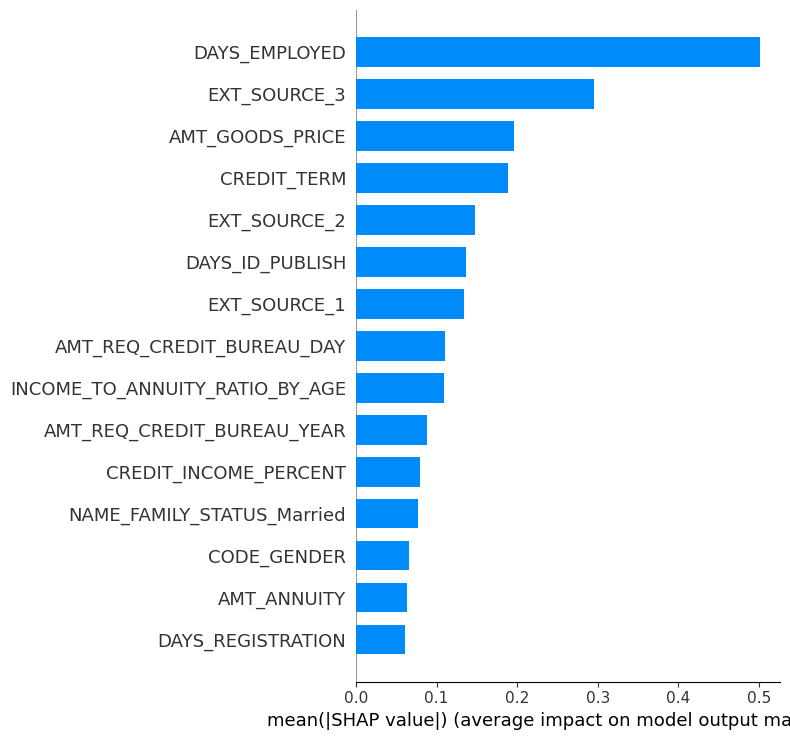

<Figure size 640x480 with 0 Axes>

In [249]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Utilisation de SHAP pour une analyse globale
explainer = shap.TreeExplainer(pipeline_lgbm.named_steps['classifier'])
shap_values = explainer.shap_values(X_train)

# Visualisation des importances globales des features avec SHAP
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=15)

# Sauvegarde du graphique des importances globales
plt.savefig('global_feature_importance.png', bbox_inches='tight', dpi=150)


## Features Importances locales

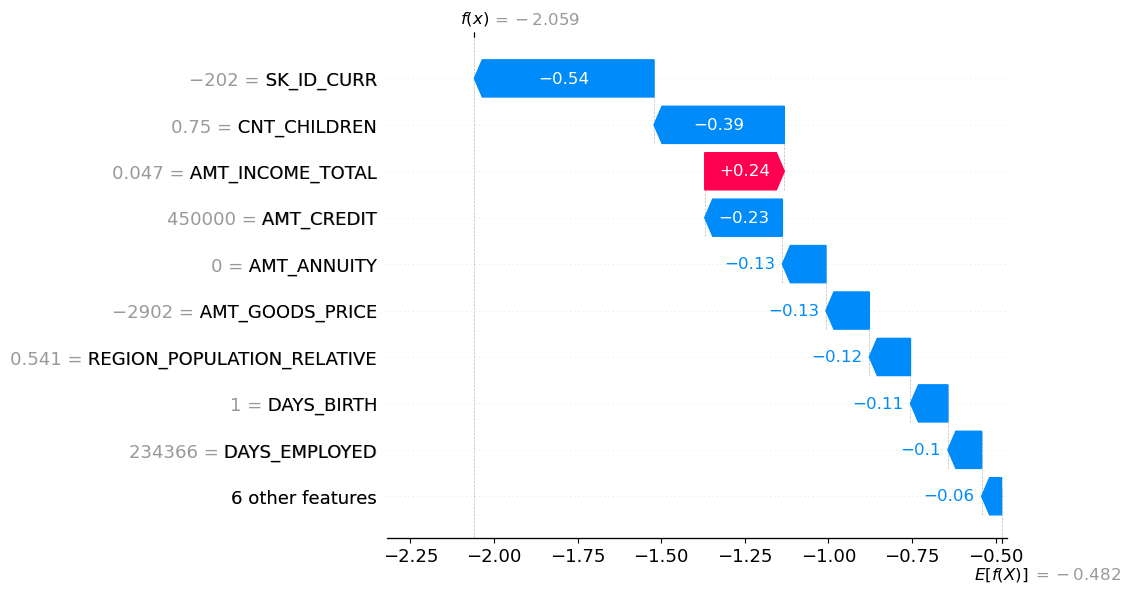

<Figure size 640x480 with 0 Axes>

In [251]:
# Filtrer les 15 premières features pour un client spécifique
def filter_top_features(shap_values, data, top_n=15):
    """Filtre les shap_values et les données pour ne garder que les top_n features les plus importantes."""
    shap_values_array = np.array(shap_values)  # Assurez-vous que shap_values est un array numpy
    # Obtenez les indices des top_n plus grandes valeurs absolues
    top_indices = np.argsort(-np.abs(shap_values_array))[:top_n]
    
    # Filtrer les valeurs SHAP et les données correspondantes
    return shap_values_array[top_indices], data[top_indices]

client_index = 0  # Exemple : premier client

# Extraire les valeurs SHAP individuelles pour le client spécifique
individual_shap_values = shap_values[client_index]

# Filtrer les 15 premières features
filtered_shap_values, filtered_data = filter_top_features(individual_shap_values, X_train.iloc[client_index])

# Création d'un objet Explanation pour le waterfall plot
explained_values = shap.Explanation(
    values=filtered_shap_values,
    base_values=explainer.expected_value,
    data=filtered_data,
    feature_names=X_train.columns
)

# Visualisation détaillée avec le waterfall_plot
shap.waterfall_plot(explained_values)

# Sauvegarde du graphique détaillé
plt.savefig('waterfall_plot_client.png', bbox_inches='tight', dpi=150)
